In [1]:
!nvidia-smi

Fri Jun  2 03:58:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   33C    P0    89W / 400W |  37443MiB / 40537MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [2]:
!pip install -qq transformers scikit-multilearn tqdm seaborn ipywidgets

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel, get_constant_schedule_with_warmup
from transformers import TrainingArguments, Trainer, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [5]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import warnings
import string
warnings.filterwarnings("ignore", 'This pattern has match groups')
import matplotlib.pyplot as plt
import matplotlib

In [6]:
seed_val = 1906350912
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [7]:
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [8]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Tersedia sejumlah %d GPU(s).' % torch.cuda.device_count())
    print('GPU yang akan digunakan:', torch.cuda.get_device_name(0))
else:
    print('Tidak mendukung GPU; hanya CPU')
    device = torch.device("cpu")

Tersedia sejumlah 1 GPU(s).
GPU yang akan digunakan: A100-SXM4-40GB


In [9]:
df_human = pd.read_csv(f"Dataset/Human_Annotated.csv", index_col="ID")
df_human.fillna("", inplace = True)
df_machine = pd.read_csv(f"Dataset/Mini_Machine_Annotated.csv", index_col="ID")
df_machine.fillna("", inplace = True)
df_unlabel = pd.read_csv(f"Dataset/Mini_unlabeled.csv", index_col="ID")
df_unlabel.fillna("", inplace = True)

In [10]:
df_all = pd.concat([df_human[["JUDUL", "ISI"]], df_machine[["JUDUL", "ISI"]], df_unlabel[["JUDUL", "ISI"]]])

In [11]:
del df_human, df_machine, df_unlabel

In [12]:
df_all = df_all.drop_duplicates()

<AxesSubplot:ylabel='Frequency'>

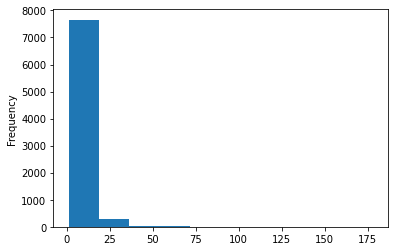

In [13]:
df_all['JUDUL'].str.split().str.len().plot.hist()

<AxesSubplot:ylabel='Frequency'>

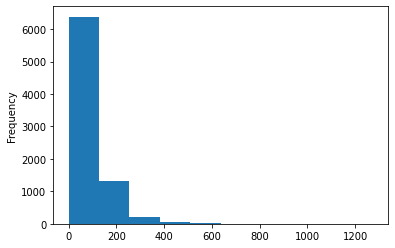

In [14]:
df_all['ISI'].str.split().str.len().plot.hist()

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_all, test_size=0.2)
del df_all

In [16]:
def generate_dataset(lst):
    """
    Generate input-output pairs for next sentence prediction from a dataframe with columns TITLE and CONTENT.
    """
    sentences = []
    temp = []
    for i, j in lst:
        if len(i) != 0 and i[-1] not in ".!?":
            i += '.'
        if len(j) != 0 and j[-1] not in ".!?":
            j += '.'
        li = re.split('(?<=[.!?]) +',i)
        lj = re.split('(?<=[.!?]) +',j)
        comb = li + ["SEP"] + lj + ["SEP"]

        for k, l in enumerate(comb):
            if (len(temp) != 0 and len(l) < 5 and l != 'SEP' and temp[-1] != 'SEP' and temp[-1] != 'SEP'):
                temp[-1] += l
            else:
                temp.append(l)
        while len(temp) > 2:
            a = temp.pop(0)
            isNSP = 1
            if (temp[0] == 'SEP'):
                temp.pop(0)
                isNSP = 0
            b = temp[0]
            if (b == 'SEP'):
                b = ""
            yield ({'a':a, 'b':b, 'nsp':isNSP})

In [17]:
max_train = len(list(generate_dataset(train.values)))
max_test = len(list(generate_dataset(test.values)))

In [18]:
print(max_train, max_test)

42891 10568


In [22]:
#--------------------------------
#  Some Parameters
#--------------------------------
MAX_SEQ_LENGTH = 256
BATCH_SIZE = 8
WARMUP_PROPORTION = 0.4
REGULARIZATION = 0.02
MODEL_NAME = "indobenchmark/indobert-large-p1"
LEARNING_RATE = 1e-5
PATH = "Model/dapt-indobert-large-p1"

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
from huggingface_hub import HfApi

user_id = HfApi().whoami()["name"]

print(f"user id '{user_id}' will be used during the example")

user id 'Hendrico' will be used during the example


In [23]:
from transformers import AutoTokenizer, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [24]:
model = None
def create_model(model):
    if model != None:
        del model
        torch.cuda.empty_cache()
    model = BertForPreTraining.from_pretrained(MODEL_NAME)
    if torch.cuda.is_available():    
        model.cuda()
    return model
model = create_model(model)

Some weights of BertForPreTraining were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
def tokenize(a, b):
    inputs = tokenizer(a, b, \
                         add_special_tokens = True, \
                          max_length = MAX_SEQ_LENGTH, \
                          padding = "max_length", \
                          truncation = True)
    tokens = inputs['input_ids']
    labels = []
    # Randomly mask some of the tokens
    masked_tokens = []
    for token in tokens:
        if token > 4 and random.random() < 0.15:
            labels.append(token)
            cum_rand = random.random()
            if (cum_rand < 0.8):
                masked_tokens.append(4)
            elif (cum_rand < 0.9):
                masked_tokens.append(random.randint(5, 30520))
            elif (cum_rand < 1):
                masked_tokens.append(token)
        else:
            labels.append(-100)
            masked_tokens.append(token)
    masked_tokens = torch.tensor([masked_tokens])
    labels = torch.tensor([labels])
    inputs = {
        'input_ids' : masked_tokens.to(device),
        'token_type_ids' : torch.tensor([inputs['token_type_ids']]).to(device),
        'attention_mask' : torch.tensor([inputs['attention_mask']]).to(device)
    }
    return {'inputs' : inputs, 'labels' : labels.to(device)}

In [32]:
# training
from tqdm import tqdm
from time import sleep
import copy
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

def train_model(model, optimizer, num_epochs=25, last_epoch=0):
    max_epoch = last_epoch + num_epochs

    for epoch_i in range(last_epoch, max_epoch):
        print(f"Epoch {epoch_i + 1} / {max_epoch}")
        model.train()
        # Reset the total loss for this epoch.
        loss_track = 0
        
        # Untuk setiap batch di training data
        pbar = tqdm(generate_dataset(train.values), desc="train", total = max_train)
        for batch in pbar:
            tokens = tokenize(batch['a'], batch['b'])
            X = tokens['inputs']
            label = tokens['labels']
            nsp = torch.tensor([batch['nsp']]).to(device)
            
            outputs = model(**X, labels=label, next_sentence_label=nsp)        

            # Categorical Cross-Entropy
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_track += loss.item()
            pbar.set_postfix(loss = str(f'{(loss_track):.2f}'))
        
            sleep(0.1)
        
        loss_track = 0
        pbar = tqdm(generate_dataset(test.values), desc="Test", total=max_test)
        for batch in pbar:
            with torch.no_grad(): 

                tokens = tokenize(batch['a'], batch['b'])
                X = tokens['inputs']
                label = tokens['labels']
                nsp = torch.tensor([batch['nsp']]).to(device)

                outputs = model(**X, labels=label, next_sentence_label=nsp)
                # Categorical Cross-Entropy
                loss = outputs.loss
                loss_track += loss.item()
            pbar.set_postfix(loss = str(f'{(loss_track):.2f}'))
        
            sleep(0.1)

        torch.save({
                  'best_model_sd' : model.state_dict(),
                  'best_optimizer_sd' : optimizer.state_dict(),
                  'best_epoch' : epoch_i+1,
                  'best_loss' : (loss_track / max_test)
                  }, f"{PATH}-{epoch_i + 1}.pt")

    return {'model' : model, 'optim' : optimizer}  

In [ ]:
%%time
model = create_model(model)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = REGULARIZATION)
info = train_model(model, optimizer, num_epochs=10, last_epoch=0)

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)